In [1]:
# import shp2cmaq
# shp2cmaq.shp2cmaq('lpr_000b21a_e.zip', 'PREABBR', '36US3', bcrs='epsg:3347')

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import BoundaryNorm, TwoSlopeNorm
from matplotlib.ticker import MaxNLocator
import pyproj
import pycno
import pyrsig
xr.set_options(keep_attrs=True)
from matplotlib.offsetbox import AnchoredText
import cartopy.crs as ccrs

/home/jkumm/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
def load_fire_emissions_data(model_run_name, start_date, end_date):
    """
    Calculates total NOx emissions per day in the file in units kg N per day.
    If 'FIRES' stream is specified, combines Canadian and US wildfire emissions.
    """
    datasets = []
    dates = pd.date_range(start_date, end_date, freq='1D').strftime('%Y%j')
    dates2 = pd.date_range(start_date, end_date, freq='1D')
    streams = ['PT_FIRES_MXCA', 'PT_WILDFIRES']
    i = 0
    for idate in dates:
        print(idate, end='\r')
        combined_emis = None
        for stream in streams:
            emis_path = f'/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/output/2023fires.v2/{model_run_name}/{idate}/CCTM_DESID1_{stream}_CMAQv54_cb6r5_ae7_aq.36US3.35.{model_run_name}.nc'
            try:
                emis_file = xr.open_dataset(emis_path)[['NO', 'NO2', 'HONO']]
                # emis_ds = emis_file.isel(TSTEP=slice(0,-1), LAY=0) * 3600 * 0.014
                emis_ds = emis_file.mean(dim=('TSTEP', 'LAY')) * 3600 * 24 * 0.014  # Convert to kg N/day
                emis_ds['NOx'] = emis_ds['NO'] + emis_ds['HONO'] + emis_ds['NO2']
                emis_ds.coords['TSTEP'] = pd.to_datetime(dates2[i], format='%Y-%m-%d')

                if combined_emis is None:
                    combined_emis = emis_ds
                else:
                    combined_emis += emis_ds
            except FileNotFoundError:
                print(f"Warning: File not found: {emis_path}")
        
        if combined_emis is not None:
            datasets.append(combined_emis)
        i += 1

    if datasets:
        emis_data = xr.concat(datasets, dim='TSTEP')
        return emis_data
    else:
        print("No emissions data loaded.")
        return None

In [4]:
def convert_to_short_tons_NOX_as_NO2(emis_data):
    nox_emis = emis_data['NOx']
    nox_emis_conv = (nox_emis * 0.001 * (46/14)) # convert from kg N to Mg (metric tons) NOx as NO2
    return nox_emis_conv

In [5]:
def convert_short_tons_to_kgN(emis_data):
    nox_emis = emis_data
    return nox_emis * 1000 * (14/46)  # convert from short tons NO2 to kg N

In [6]:
START_DATE = '2023-05-01'
END_DATE = '2023-09-30'
DROOT = '/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/run/final_scale_factors/'
RUN_NAME = 'SCALE8_FINAL'
BASE_NAME = 'BASE0'
OUTPUT_DIR = '/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/manuscript/results/final_plots/'
gf = pyrsig.open_ioapi('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/input/mcip/aqm.t12z.grdcro2d_20230501.ncf')
proj = pyproj.Proj(gf.crs_proj4)

In [7]:
posterior_emissions = load_fire_emissions_data(RUN_NAME, START_DATE, END_DATE)
prior_emissions = load_fire_emissions_data(BASE_NAME, START_DATE, END_DATE)

In [8]:
# posterior_emissions_short_tons = convert_to_short_tons_NOX_as_NO2(posterior_emissions)
# prior_emissions_short_tons = convert_to_short_tons_NOX_as_NO2(prior_emissions)

In [9]:
# emissions_changes_short_tons = posterior_emissions_short_tons.sum(dim='TSTEP') - prior_emissions_short_tons.sum(dim='TSTEP')

In [10]:
f = pyrsig.open_ioapi('./ne_10m_admin_1_states_provinces.iso_3166_2.36US3.IOAPI.nc')


In [11]:
f

<xarray.Dataset>
Dimensions:              (TSTEP: 1, VAR: 249, DATE-TIME: 2, LAY: 1, ROW: 148,
                          COL: 172)
Coordinates:
  * TSTEP                (TSTEP) datetime64[ns] 1970-01-01
  * LAY                  (LAY) float32 0.5
  * ROW                  (ROW) float64 0.5 1.5 2.5 3.5 ... 145.5 146.5 147.5
  * COL                  (COL) float64 0.5 1.5 2.5 3.5 ... 169.5 170.5 171.5
Dimensions without coordinates: VAR, DATE-TIME
Data variables: (12/250)
    TFLAG                (TSTEP, VAR, DATE-TIME) int32 ...
    ISO_3166_2_AW_X01_   (TSTEP, LAY, ROW, COL) float32 ...
    ISO_3166_2_BM_DEV    (TSTEP, LAY, ROW, COL) float32 ...
    ISO_3166_2_BM_HA     (TSTEP, LAY, ROW, COL) float32 ...
    ISO_3166_2_BM_HAM    (TSTEP, LAY, ROW, COL) float32 ...
    ISO_3166_2_BM_PAG    (TSTEP, LAY, ROW, COL) float32 ...
    ...                   ...
    ISO_3166_2_US_WI     (TSTEP, LAY, ROW, COL) float32 ...
    ISO_3166_2_US_WV     (TSTEP, LAY, ROW, COL) float32 ...
    ISO_3166_2_US_WY     (TSTEP, LAY, ROW, COL) float32 ...
    ISO_3166_2_VE_I      (TSTEP, LAY, ROW, COL) float32 ...
    ISO_3166_2_TOT       (TSTEP, LAY, ROW, COL) float32 ...
    ISO_3166_2_DOM       (TSTEP, LAY, ROW, COL) int32 ...
Attributes: (12/36)
    PRJNAME:        LamCon_40N_97W
    XORIG:          -2952000.0
    YORIG:          -2772000.0
    XCELL:          36000.0
    YCELL:          36000.0
    NCOLS:          172
    ...             ...
    TSTEP:          149322533
    NVARS:          249
    VAR-LIST:       ISO_3166_2_AW_X01_ISO_3166_2_BM_DEVISO_3166_2_BM_HAISO_31...
    FILEDESC:       title: ./ne_10m_admin_1_states_provinces.iso_3166_2.36US3...
    HISTORY:        Created 2025-09-15T14:44:40                              ...
    crs_proj4:      +proj=lcc +lat_1=33.0 +lat_2=45.0 +lat_0=40.0 +lon_0=-97....

In [12]:
# f = pyrsig.open_ioapi('/work/ROMO/gis_rasters/NOAA/NOAA_CLIMATE_REGIONS_36US3.nc')
# ordkeys = [k[5:] for k in sorted(f.data_vars) if k not in ('NOAA_DOM', 'NOAA_TOT', 'TFLAG')]
# Z = f['NOAA_DOM'].where(lambda x: x>0)
# Z.attrs['units'] = ''
# Z.attrs['long_name'] = 'Region'
# qm = Z.plot(cmap='tab20', levels=np.arange(len(ordkeys) + 2) + .5)
# qm.colorbar.set_ticks(np.arange(len(ordkeys)) + 1)
# qm.colorbar.set_ticklabels(ordkeys)
# qm.colorbar.set_label('Region')
# qm.axes.set(facecolor='gainsboro', title='Region Definitions', xticks=[], yticks=[], xlabel='', ylabel='')
# pycno.cno(f.crs_proj4).drawstates(resnum=3)
# del f
# qm.figure.savefig('regions.png')


In [13]:
prior_emissions_total = prior_emissions.sum(dim='TSTEP')['NOx']
posterior_emissions_total = posterior_emissions.sum(dim='TSTEP')['NOx']
emissions_changes_total = posterior_emissions_total - prior_emissions_total

In [14]:
prior_emissions_total

<xarray.DataArray 'NOx' (ROW: 148, COL: 172)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Dimensions without coordinates: ROW, COL
Attributes:
    long_name:  NO              
    units:      mol s-1         
    var_desc:   Emission Rate of NO from PT_FIRES_MXCA emissions             ...

In [15]:
import re

province_mask_vars = [v for v in f.data_vars if re.match(r'ISO_3166_2_CA_[A-Z]{2}', v)]

province_results = []

for mask_var in province_mask_vars:
    province_abbr = mask_var.split('_')[-1]
    # Select the first TSTEP and LAY to get a 2D mask
    mask2d = f[mask_var].isel(TSTEP=0, LAY=0).values  # shape: (ROW, COL)
    # Multiply and sum
    prior_weighted = round(float((prior_emissions_total * mask2d).sum()))
    posterior_weighted = round(float((posterior_emissions_total * mask2d).sum()))
    province_results.append({
        'province': province_abbr,
        'Prior (EMBER)': prior_weighted,
        'Posterior': posterior_weighted
    })

province_df = pd.DataFrame(province_results)
province_df.to_csv('canadian_province_fire_emissions_totals.csv', index=False)

In [16]:
# import re

# province_mask_vars = [v for v in f.data_vars if re.match(r'ISO_3166_2_CA_[A-Z]{2}', v)]

# province_results = []

# for mask_var in province_mask_vars:
#     province_abbr = mask_var.split('_')[-1]
#     # Select the first TSTEP and LAY to get a 2D mask and convert to boolean
#     mask2d = (f[mask_var].isel(TSTEP=0, LAY=0).values > 0.0)  # True/False mask
#     # Use boolean mask to sum only cells belonging to this province
#     prior_weighted = float(prior_emissions_total.values[mask2d].sum())
#     posterior_weighted = float(posterior_emissions_total.values[mask2d].sum())
#     province_results.append({
#         'province': province_abbr,
#         'prior_emissions_short_tons': prior_weighted,
#         'posterior_emissions_short_tons': posterior_weighted
#     })

# province_df = pd.DataFrame(province_results)
# province_df.to_csv('canadian_province_fire_emissions_totals.csv', index=False)

In [17]:
province_df

,province,Prior (EMBER),Posterior
0,AB,101714056,81838640
1,BC,89513488,80060416
2,MB,6331158,5767009
3,NB,24960,29906
4,NL,692211,658496
5,NS,507040,315798
6,NT,78357200,64093104
7,NU,11781,11630
8,ON,20848144,17989790
9,PE,824,824


In [18]:
# Add two new columns with zeros as placeholder data
province_df_short_tons_finn = [476441, 623631, 13283, 24, 455, 880, 179373, 0, 43362, 0, 81207, 166469, 15017]
province_df_short_tons_cracmm2 = [162845, 124182, 10537, 163, 1583, 443, 162395, 26, 27364, 4, 327944, 66448, 42]

province_df['FINN'] = convert_short_tons_to_kgN(np.array(province_df_short_tons_finn))
province_df['CRACMM2'] = convert_short_tons_to_kgN(np.array(province_df_short_tons_cracmm2))
# Save the updated DataFrame to CSV
province_df.to_csv('canadian_fire_emissions_totals_with_comparison.csv', index=False)

In [19]:
province_df[['Prior (EMBER)', 'Posterior', 'FINN', 'CRACMM2']] = province_df[['Prior (EMBER)', 'Posterior', 'FINN', 'CRACMM2']] / 1e9

In [20]:
province_df

,province,Prior (EMBER),Posterior,FINN,CRACMM2
0,AB,1.017141e-01,8.183864e-02,0.145004,0.049562
1,BC,8.951349e-02,8.006042e-02,0.189801,0.037795
2,MB,6.331158e-03,5.767009e-03,0.004043,0.003207
3,NB,2.496000e-05,2.990600e-05,0.000007,0.000050
4,NL,6.922110e-04,6.584960e-04,0.000138,0.000482
5,NS,5.070400e-04,3.157980e-04,0.000268,0.000135
6,NT,7.835720e-02,6.409310e-02,0.054592,0.049425
7,NU,1.178100e-05,1.163000e-05,0.000000,0.000008
8,ON,2.084814e-02,1.798979e-02,0.013197,0.008328
9,PE,8.240000e-07,8.240000e-07,0.000000,0.000001


In [21]:
# Define province groups
west = ['SK', 'AB', 'BC', 'NT', 'YT']
central = ['MB', 'NU']
east = ['NL', 'NS', 'NB', 'QC', 'ON', 'PE']

# Helper to sum over a region
def sum_region(df, provs):
    return df[df['province'].isin(provs)].sum(numeric_only=True)

# Calculate regional totals
canada_total = province_df.sum(numeric_only=True)
west_total = sum_region(province_df, west)
central_total = sum_region(province_df, central)
east_total = sum_region(province_df, east)

# Append rows to DataFrame
province_df = pd.concat([
    province_df,
    pd.DataFrame([{
        'province': 'Canada',
        **canada_total
    }]),
    pd.DataFrame([{
        'province': 'W. Canada',
        **west_total
    }]),
    pd.DataFrame([{
        'province': 'C. Canada',
        **central_total
    }]),
    pd.DataFrame([{
        'province': 'E. Canada',
        **east_total
    }])
], ignore_index=True)



In [22]:
province_df['GFED*'] = np.nan
province_df['GFAS*'] = np.nan
province_df.loc[province_df['province'] == 'Canada', 'GFED*'] = 0.472745
province_df.loc[province_df['province'] == 'Canada', 'GFAS*'] = 0.850082

In [23]:
province_df

,province,Prior (EMBER),Posterior,FINN,CRACMM2,GFED*,GFAS*
0,AB,1.017141e-01,8.183864e-02,0.145004,0.049562,NaN,NaN
1,BC,8.951349e-02,8.006042e-02,0.189801,0.037795,NaN,NaN
2,MB,6.331158e-03,5.767009e-03,0.004043,0.003207,NaN,NaN
3,NB,2.496000e-05,2.990600e-05,0.000007,0.000050,NaN,NaN
4,NL,6.922110e-04,6.584960e-04,0.000138,0.000482,NaN,NaN
5,NS,5.070400e-04,3.157980e-04,0.000268,0.000135,NaN,NaN
6,NT,7.835720e-02,6.409310e-02,0.054592,0.049425,NaN,NaN
7,NU,1.178100e-05,1.163000e-05,0.000000,0.000008,NaN,NaN
8,ON,2.084814e-02,1.798979e-02,0.013197,0.008328,NaN,NaN
9,PE,8.240000e-07,8.240000e-07,0.000000,0.000001,NaN,NaN


In [24]:
# from plotnine import *
# import pandas as pd

# # Select only the regional rows (make sure names match exactly)
# regions = ['Canada', 'W. Canada', 'C. Canada', 'E. Canada']
# plot_df = province_df[province_df['province'].isin(regions)].copy()
# plot_df['region'] = plot_df['province']  # for clarity

# # Melt for bar plotting
# bar_df = plot_df.melt(id_vars='region', value_vars=['Prior (EMBER)', 'Posterior'],
#                       var_name='Inventory', value_name='NOx')

# # Set categorical order for Inventory and region
# bar_df['Inventory'] = pd.Categorical(bar_df['Inventory'], categories=['Prior (EMBER)', 'Posterior'], ordered=True)
# bar_df['region'] = pd.Categorical(bar_df['region'], categories=['Canada', 'W. Canada', 'C. Canada', 'E. Canada'], ordered=True)
# plot_df['region'] = pd.Categorical(plot_df['region'], categories=['Canada', 'W. Canada', 'C. Canada', 'E. Canada'], ordered=True)

# # Format NOx values as string with commas for labels
# bar_df['NOx_label'] = bar_df['NOx'].map('{:,.0f}'.format)

# # Prepare comparison DataFrame for AGES and FINN points
# comparison_df = pd.DataFrame({
#     'region': list(plot_df['region']) * 2,
#     'NOx': list(plot_df['CRACMM2']) + list(plot_df['FINN']),
#     'Reference': ['CRACMM2'] * len(plot_df) + ['FINN'] * len(plot_df)
# })

# # Build the plot
# p = (
#     ggplot(bar_df, aes(x='region', y='NOx', fill='Inventory'))
#     + geom_bar(stat='identity', position='dodge', width=0.7)
#     # AGES: solid black circle, no legend
#     + geom_point(
#         comparison_df[comparison_df['Reference'] == 'AGES'],
#         aes(x='region', y='NOx'),
#         color='black', fill='dimgray', shape='o', size=5, show_legend=True
#     )
#     # FINN: solid red triangle, no legend
#     + geom_point(
#         comparison_df[comparison_df['Reference'] == 'FINN'],
#         aes(x='region', y='NOx'),
#         color='black', fill='firebrick', shape='^', size=5, show_legend=True
#     )
#     + scale_fill_manual(values=['#4C72B0', '#55A868'], name="Inventory")
#     + labs(
#         x='Region',
#         y='NO$_x$ Emissions (short tons)',
#         title='Canadian Wildfire NO$_x$ Emissions Comparison: May-Sep 2023'
#     )
#     + theme_bw()
#     + theme(
#         axis_text_x=element_text(rotation=20, ha='right', size=12),
#         axis_title=element_text(size=14),
#         legend_title=element_text(size=12),
#         legend_text=element_text(size=11),
#         figure_size=(8, 6)
#     )
#     + guides(
#         fill=guide_legend(title="Inventory"),
#         shape=guide_legend(title=None),
#         color=guide_legend(title=None)
#     )
# )
# print(p)

/tmp/ipykernel_2146025/2170361646.py:141: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/jkumm/.local/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 6 rows containing missing values.
/home/jkumm/.local/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 3 rows containing missing values.
/home/jkumm/.local/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 3 rows containing missing values.


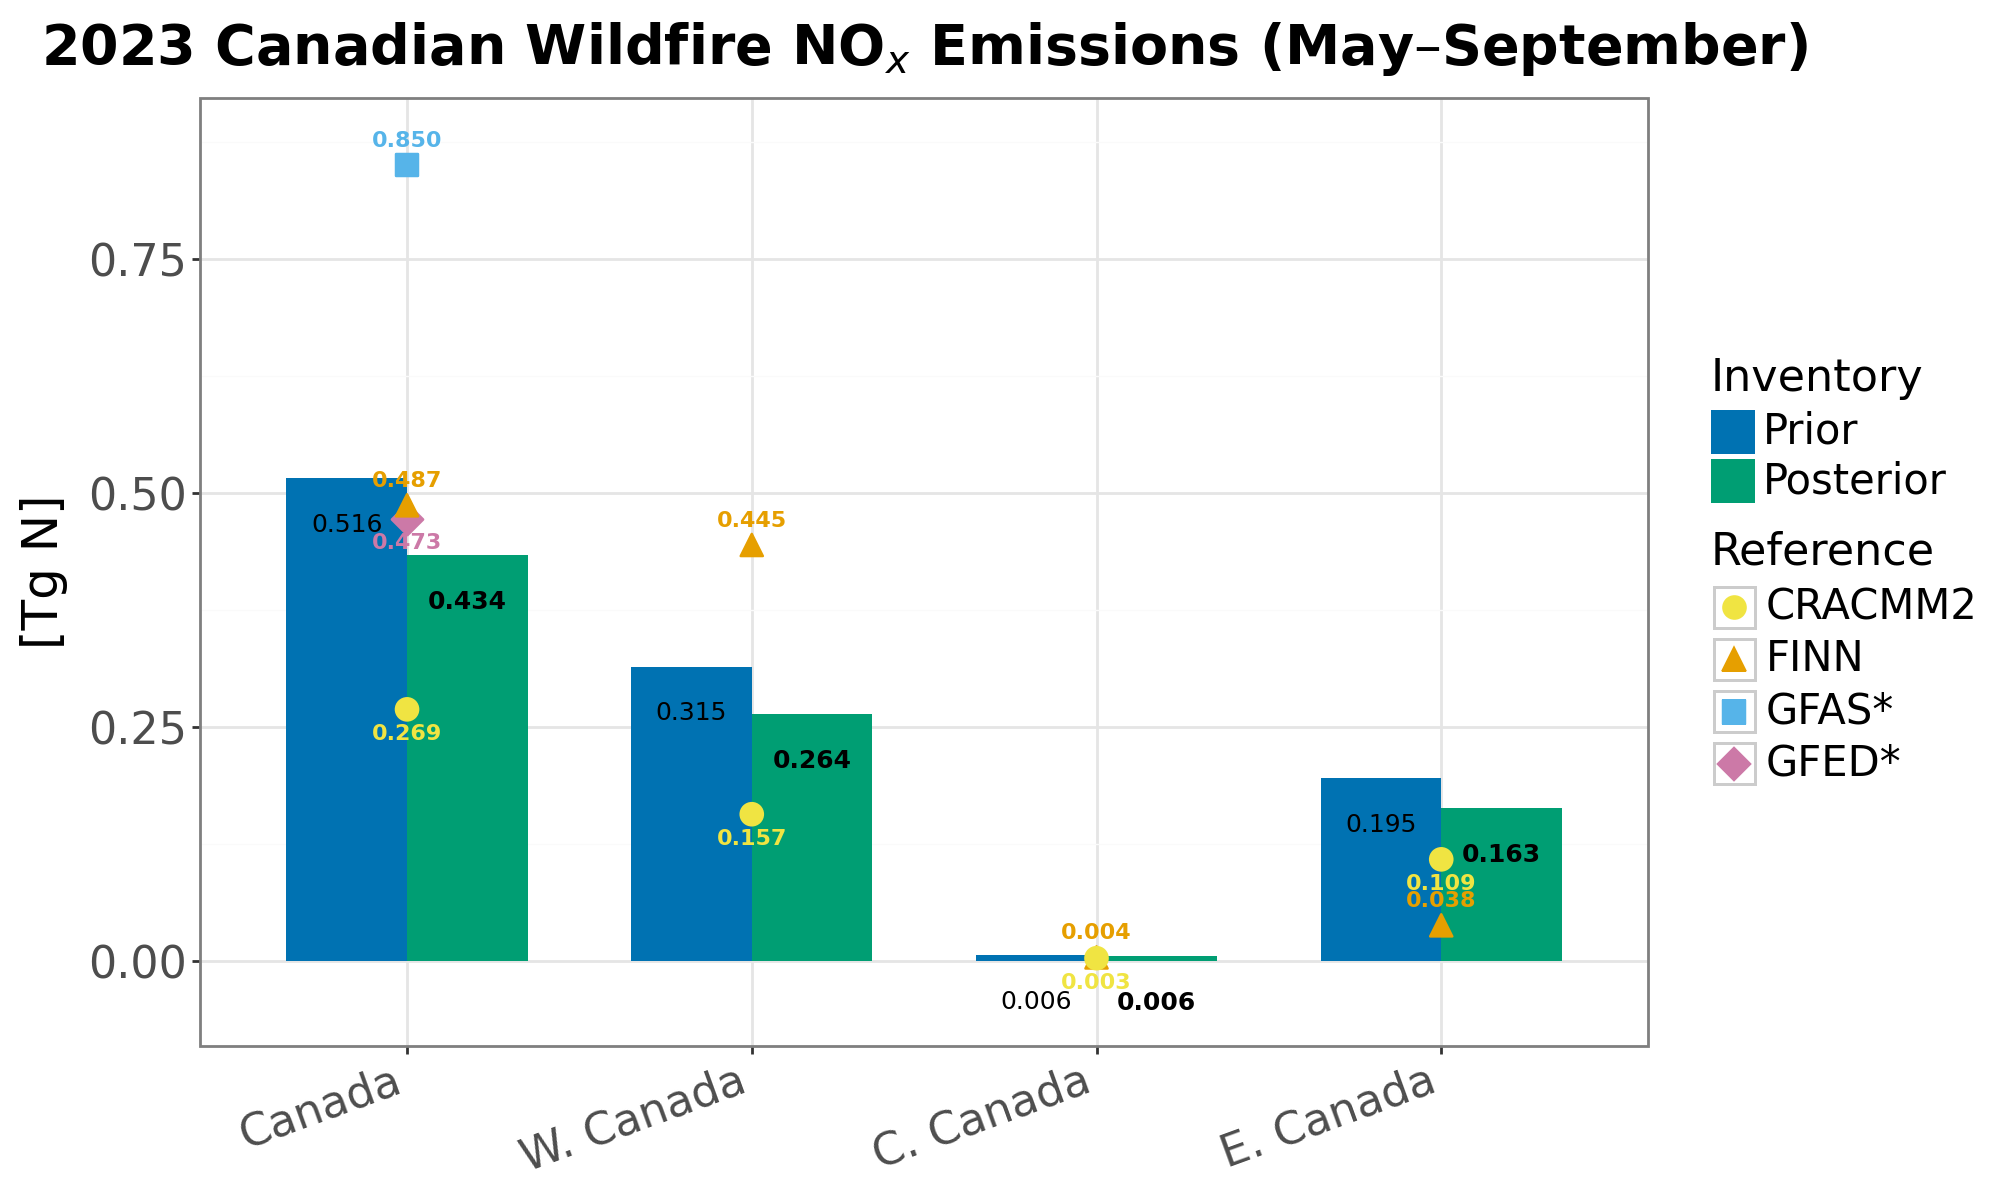

In [25]:
from plotnine import *
import pandas as pd

# Regions to plot (order locked)
regions = ['Canada', 'W. Canada', 'C. Canada', 'E. Canada']

# Filter/prepare
plot_df = province_df[province_df['province'].isin(regions)].copy()
plot_df['region'] = pd.Categorical(plot_df['province'], categories=regions, ordered=True)

# Bars: Prior vs Posterior
bar_df = (
    plot_df
    .melt(id_vars='region',
          value_vars=['Prior (EMBER)', 'Posterior'],
          var_name='Inventory', value_name='NOx')
)
bar_df['Inventory'] = bar_df['Inventory'].replace({
    'Prior (EMBER)': 'Prior',
    'Posterior': 'Posterior'
})
bar_df['Inventory'] = pd.Categorical(bar_df['Inventory'],
                                     categories=['Prior', 'Posterior'],
                                     ordered=True)

# Points: EPA revised vs FINN, GFAS, GFED
comparison_df = pd.DataFrame({
    'region': list(plot_df['region']) * 4,  # CRACMM2, FINN, GFAS, GFED
    'NOx': list(plot_df['CRACMM2']) + list(plot_df['FINN']) + list(plot_df['GFAS*']) + list(plot_df['GFED*']),
    'Reference': (['CRACMM2'] * len(plot_df) +
                  ['FINN'] * len(plot_df) +
                  ['GFAS*'] * len(plot_df) +
                  ['GFED*'] * len(plot_df))
})
# prepare formatted labels (bars bigger, only show point labels for Canada)
bar_df['NOx_label'] = bar_df['NOx'].map('{:.3f}'.format)
comparison_df['label'] = comparison_df['NOx'].map('{:.3f}'.format)

# plotting jitter object reused for point+label so labels sit over the points
# pos = position_jitter(width=0.15, height=0)

# Plot
p = (
    ggplot(bar_df, aes('region', 'NOx'))
    + geom_bar(aes(fill='Inventory'),
               stat='identity', position=position_dodge(width=0.7), width=0.7
    )
    # Bar labels: smaller text and no white background (use geom_text instead of geom_label)
    + geom_text(
        data=bar_df[bar_df['Inventory'] == 'Prior'],
        mapping=aes(x='region', y='NOx', label='NOx_label', group='Inventory'),
        position=position_dodge(width=0.7),
        nudge_y=-0.05,
        nudge_x=-0.175,            # Prior labels shifted left
        size=9,                   # smaller label
        # fontweight='bold',
        color='black',
        show_legend=False
    )
    + geom_text(
        data=bar_df[bar_df['Inventory'] == 'Posterior'],
        mapping=aes(x='region', y='NOx', label='NOx_label', group='Inventory'),
        position=position_dodge(width=0.7),
        nudge_y=-0.05,
        nudge_x=0.175,             # Posterior labels shifted right
        size=9,                   # smaller label
        fontweight='bold',
        color='black',
        show_legend=False
    )
    # Solid circle for CRACMM2, solid triangle for FINN
    + geom_point(
        aes(x='region', y='NOx', shape='Reference', color='Reference'),
        data=comparison_df,
        size=4,
        # position=pos,
    )
    #     # Numeric labels for each point, centered above the point, color-coded to the Reference
    # + geom_text(
    #     mapping=aes(x='region', y='NOx', label='label', color='Reference'),
    #     data=comparison_df,
    #     # position=pos,        # use same jitter so text is aligned with the point
    #     nudge_y=0.04,          # place above the point; tweak (-0.2 .. -0.8) if needed
    #     size=8,              # publication-friendly small size
    #     fontweight='bold',
    #     show_legend=False
    # )
        # Labels for FINN and CRACMM2 (above points)
    + geom_text(
        mapping=aes(x='region', y='NOx', label='label', color='Reference'),
        data=comparison_df[comparison_df['Reference'].isin(['FINN', 'GFAS*'])],
        nudge_y=0.026,
        size=8,
        fontweight='bold',
        show_legend=False
    )
    # Labels for GFAS and GFED (below points)
    + geom_text(
        mapping=aes(x='region', y='NOx', label='label', color='Reference'),
        data=comparison_df[comparison_df['Reference'].isin(['CRACMM2', 'GFED*'])],
        nudge_y=-0.026,
        size=8,
        fontweight='bold',
        show_legend=False
    )

    # Scales
    + scale_fill_manual(values=['#0072b2', '#009e73'], name=None)  
    + scale_shape_manual(name=None,
                         values={'CRACMM2': 'o', 'FINN': '^', 'GFAS*': 's', 'GFED*': 'D'})
    + scale_color_manual(name=None,
                         values={'CRACMM2': '#F0E442', 
                                 'FINN': '#E69F00',
                                'GFAS*': '#56B4E9',
                                 'GFED*': '#CC79A7'
                                 })

    # Labels/theme
    + labs(
        x='',
        y='[Tg N]',
        title='2023 Canadian Wildfire NO$_x$ Emissions (May–September)'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=20, ha='right', size=16),
        axis_text_y=element_text(size=16),
        axis_title=element_text(size=18),
        legend_title=element_text(size=16),
        legend_text=element_text(size=15),
        plot_title=element_text(size=20, weight='bold'),
        figure_size=(10, 6),
    )

    # Legend ordering (bars first, then points)
    + guides(fill=guide_legend(order=1),
             color=guide_legend(order=2),
             shape=guide_legend(order=2))
)

print(p)

In [26]:
plot_df

,province,Prior (EMBER),Posterior,FINN,CRACMM2,GFED*,GFAS*,region
13,Canada,0.516418,0.433525,0.487000,0.269036,0.472745,0.850082,Canada
14,W. Canada,0.314781,0.264282,0.444631,0.157017,NaN,NaN,W. Canada
15,C. Canada,0.006343,0.005779,0.004043,0.003215,NaN,NaN,C. Canada
16,E. Canada,0.195294,0.163464,0.038326,0.108805,NaN,NaN,E. Canada


In [27]:
gfas_path = "/work/MOD3APP/jbeidler/global/gfas"
gfas_file = xr.open_dataset(f"{gfas_path}/GFAS121_NOX.ncf")


In [28]:
import pyrsig
import xarray as xr

statepath = '/work/ROMO/gis_rasters/shp2cmaq/NaturalEarth/ne_10m_admin_1_states_provinces.iso_3166_2.36US3.IOAPI.nc'
f2 = pyrsig.open_ioapi(statepath)
isca = xr.concat([f2[k] for k in sorted(f2.data_vars) if k.startswith('ISO_CA_')], dim='STATE').sum('STATE') / f2['ISO_TOT']
isca = isca.fillna(0)
isca = isca.isel(TSTEP=0, LAY=0)

In [29]:
isca

<xarray.DataArray (ROW: 148, COL: 172)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    TSTEP    datetime64[ns] 1970-01-01
    LAY      float32 0.5
  * ROW      (ROW) float64 0.5 1.5 2.5 3.5 4.5 ... 143.5 144.5 145.5 146.5 147.5
  * COL      (COL) float64 0.5 1.5 2.5 3.5 4.5 ... 167.5 168.5 169.5 170.5 171.5
Attributes:
    long_name:  ISO_CA_AB       
    var_desc:   Fractional overlap of ISO_CA_AB with 36US3                   ...
    units:      1

In [30]:
gfas_file

<xarray.Dataset>
Dimensions:    (time: 7669, longitude: 3600, latitude: 1800)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-02T12:00:00 ... 2023-12-31T12:00:00
  * longitude  (longitude) float32 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
Data variables:
    noxfire    (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Sep 11 10:23:28 2024: cdo -f nc4 -z zip_6 mergetime mer...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...
    Title:        NILU-GFASv1.2.1 vegetation fire emissions 2003-2023

In [31]:
gfas_data = gfas_file['noxfire'].sel(time=slice('2023-05-01', '2023-09-30')).sum('time') * 24 * 3600 * 14/46  # kg N/m2/day

In [32]:
# robust time selection (handles timestamps like '2023-05-01T12:00:00')
times = gfas_file['time'].values
start = np.datetime64('2023-05-01')
end = np.datetime64('2023-09-30')  # inclusive date
mask = (times >= start) & (times <= end + np.timedelta64(1, 'D') - np.timedelta64(1, 'ns'))
idx = np.where(mask)[0]
print(f"GFAS time steps in selection: {idx.size}")
if idx.size == 0:
    raise RuntimeError("No GFAS time steps found in 2023-05-01..2023-09-30; inspect gfas_file['time']")

# use isel with integer indices to avoid label-matching issues, then sum over time
gfas_data = gfas_file['noxfire'].isel(time=idx).sum(dim='time') * 24 * 3600 * (14.0/46.0)  # kg N / m^2 (converted)

GFAS time steps in selection: 153


In [33]:
gfas_data

<xarray.DataArray 'noxfire' (latitude: 1800, longitude: 3600)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
Attributes:
    long_name:  Wildfire flux of Nitrogen Oxides NOx
    units:      kg m**-2 s**-1

In [34]:
# Quick checks
print("gfas_data dims, coords:", gfas_data.dims, gfas_data.coords.keys())
for k in ('latitude','lat','longitude','lon'):
    if k in gfas_file:
        print("Found GFAS coord:", k)
print("gfas_data attrs:", getattr(gfas_data, 'attrs', {}))

gfas_data dims, coords: ('latitude', 'longitude') KeysView(Coordinates:
  * longitude  (longitude) float32 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95)
Found GFAS coord: latitude
Found GFAS coord: longitude
gfas_data attrs: {'long_name': 'Wildfire flux of Nitrogen Oxides NOx', 'units': 'kg m**-2 s**-1'}
